# 2. Luther – Cleaning and Exploration

## Imports & Versions

In [ ]:
import numpy as np
import pandas as pd
import requests
# from bs4 import BeautifulSoup
import pickle
from datetime import datetime, timedelta
import time
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

% matplotlib inline

# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# import os
# chromedriver = "/Applications/chromedriver"
# os.environ["webdriver.chrome.driver"] = chromedriver

In [ ]:
list_of_imports = [('Numpy', np), 
                   ('Pandas', pd), 
#                   ('Beautiful Soup', BeautifulSoup), 
#                    ('Selenium', webdriver)
                  ]

for mod in list_of_imports:
    print(f"{mod[0]}: {mod[1].__version__}")

print("Python:", sys.version)

## Necessary Functions and Variables

In [ ]:
# All the LGA-ORD flights:

flight_urls = [
"http://flightaware.com/live/flight/AAL321/history/20171003/0130Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL371/history/20171003/0030Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL359/history/20171002/2330Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL361/history/20171002/2230Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL383/history/20171002/2200Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL345/history/20171002/2130Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL343/history/20171002/2030Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL358/history/20171002/1930Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL187/history/20171002/1830Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL332/history/20171002/1730Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL390/history/20171002/1630Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL337/history/20171002/1530Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL328/history/20171002/1430Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL373/history/20171002/1330Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL1619/history/20171002/1230Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL289/history/20171002/1130Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL304/history/20171002/1030Z/KLGA/KORD"
]

In [ ]:
flights = []
for url in flight_urls:
    fn_p = re.compile(r'AAL\d{3,4}')
    rn_p = re.compile(r'\d{4}Z')
    fn = fn_p.search(url).group()
    rn = rn_p.search(url).group()
    flights.append((fn,rn))

In [ ]:
# helper functions

def diff_minutes(a, b):
    diff = int((a.timestamp() - b.timestamp()) // 60)
    return diff

def day_quarters(dt_obj):
    """
    Given a datetime object, extracts the hour, then returns a number (int)
    0-3 indicating the quarter of the day.
    """
    h = dt_obj.hour
    
    if h < 6:
        q = 0
    elif 6 <= h < 12:
        q = 1
    elif 12 <= h < 18:
        q = 2
    else:
        q = 3
    
    return q

In [585]:
# variables for plot formatting

# 60 min segments
hours = np.array([-1+i for i in range(10)])
minutes = 60 * hours

# 30 min segments
segments_30 = np.array([-2+i for i in range(17)])
minutes_30 = 30 * segments_30

# 15 min segments
segments_15 = np.array([-4+i for i in range(37)])
minutes_15 = 15 * segments_15

# 10 min segments
segments_10 = np.array([-6+i for i in range(55)])
minutes_10 = 10 * segments_10

# 10 min segments over three hours
minutes_10_3 = 10 * np.array([-6+i for i in range(19)])

# 5 min segments over two hours
segments_5 = np.array([-12+i for i in range(25)])
minutes_5 = 5 * segments_5

# 5 min segments over three hours
minutes_5_3 = 5 * np.array([-12+i for i in range(37)])

# for use in ticks
days = ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su']

## Cleaning 

For explanations of every single step, scroll down to **Cleaning Prep**.

In [660]:
def clean_it_up(df):
    """
    Includes all the operations necessary to clean and format any dataframe
    of flights, given the following nine columns:
    1. airline: airline as string
    2. f_num: flight number, e.g. AAL321
    3. origin: 3-letter airport code of origin
    4. dest: 3-letter airport code of destination
    5. date: date of flight, datetime.date() object
    6. land_act: actual landing time, datetime object
    7. arr_act: actual gate arrival time, datetime object
    8. land_sch: scheduled landing time, datetime object
    9. arr_sch: scheduled gate arrival time, datetime object
    ---
    IN: pandas dataframe of scraped flight data
    OUT: pandas dataframe, sorted by date and then f_num
    """
    
    types = ['land', 'arr']
    
    # because it's easier to look at columns in this order
    df = df.filter(['airline',
                    'f_num', 
                    'origin', 
                    'dest', 
                    'date', 
                    'land_act', 
                    'land_sch', 
                    'arr_act', 
                    'arr_sch'])
    
    
    # add lateness_land and lateness_arr columns
    for n in types:
        df['lateness_' + n] = (df
         .apply(lambda row: diff_minutes(row[n + '_act'], row[n + '_sch']), axis=1))
    
    # advance land_act and arr_act dates one day if either after midnight
    for n in types:
        df.loc[df['lateness_' + n] < -120, n + '_act'] = (df[n + '_act']
         .apply(lambda x: x + timedelta(days=1)))
    
    # correct lateness values if actual arrivals after midnight
    for n in types:
        col = 'lateness_' + n
        df.loc[(df[col] < -120), col] = df[col] + 1440
    
    # drop records where flight was later than 8 hours
    # this is the 'semi-canceled' threshold, and eliminates two flights
    # that arrive in the morning of the day following that on which they
    # were originally scheduled
    # this case does not show up in the 'cleaning prep' subset...
    df.drop(df[df.lateness_arr > 480].index, inplace=True)
    
    # add columns for taxi time (between landing and gate arrival)
    for n in ['act', 'sch']:
        df['taxi_' + n] = (df
         .apply(lambda row: diff_minutes(row['arr_' + n], row['land_' + n]), axis=1))
    
    # drop records with negative scheduled taxi time
    df.drop(df[df.taxi_sch < 0].index, inplace=True)
    
    # add column for hour of day
    df['hour_of_day'] = df.apply(lambda x: x.arr_sch.hour, axis=1)
    
    # add column for quarter of day
    df['q_of_day'] = df.apply(lambda x: day_quarters(x.arr_sch), axis=1)
    
    # add column for day of week
    df['weekday'] = df.apply(lambda x: x.arr_sch.weekday(), axis=1)
    
    # add four columns where full datetimes are converted to times
    for col in df.columns[5:9]:
        df[col + '_t'] = df.apply(lambda row: row[col].time(), axis=1)
    
    # filter the outliers beyond the upper whisker 
    # (rows with lateness_arr values that exceed 51 min)
    df_chop = df[df.lateness_arr <= 51]

    for x in [df, df_chop]:
        x = x.sort_values(by='f_num').reset_index(drop=True)
      
    return df_chop, df

In [727]:
with open('../data/AAL_complete.pkl', 'rb') as pf: 
    AAL_raw = pickle.load(pf)

#### Extraction of test set for later (the last week of data)...

In [728]:
sep27 = datetime(2017, 9, 27).date()

In [729]:
AAL_raw.shape

(1960, 9)

In [730]:
AAL_raw_test = AAL_raw[AAL_raw.date > sep27]

In [731]:
AAL_raw_train = AAL_raw[AAL_raw.date <= sep27]

In [732]:
AAL_raw_test.shape

(106, 9)

In [733]:
AAL_raw_train.shape

(1854, 9)

Then clean both based on observations of the training set:

In [734]:
AAL_test, AAL_test_unfiltered = clean_it_up(AAL_raw_test)

In [735]:
AAL, AAL_unfiltered = clean_it_up(AAL_raw_train)

Save both:

In [736]:
with open('../data/AAL_test.pkl', 'wb') as pf:
    pickle.dump(AAL_test, pf)

In [737]:
with open('../data/AAL_clean.pkl', 'wb') as pf:
    pickle.dump(AAL, pf)

## Exploration

Having removed a few values that be considered as "semi-canceled" (e.g. **lateness_arr** > 8 hrs), there are still a number of outliers, as shown here:

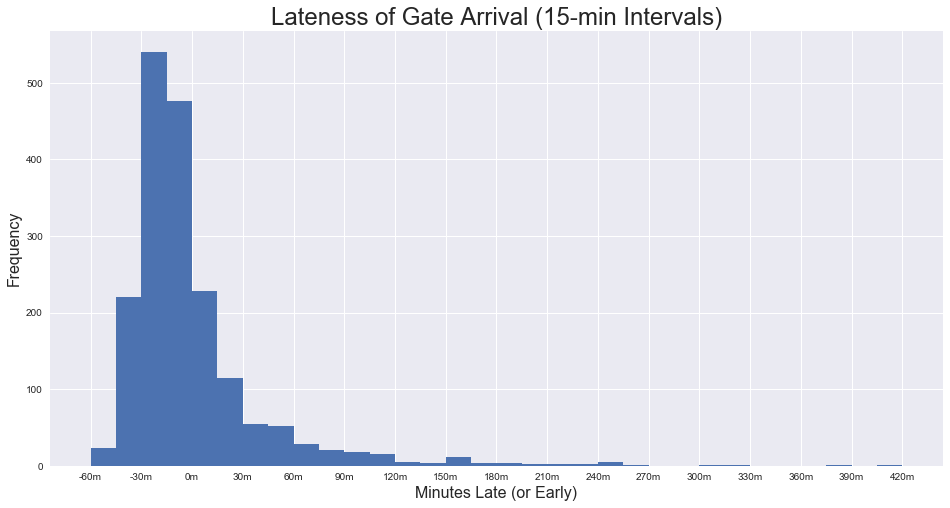

In [763]:
x = AAL_unfiltered.lateness_arr

plt.figure(figsize=(16,8))
plt.hist(x, bins=32, range=[-60,420])
plt.xticks(minutes_30, [str(i)+'m' for i in minutes_30])
plt.xlabel("Minutes Late (or Early)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Lateness of Gate Arrival (15-min Intervals)", fontsize=24)

# plt.savefig('../img/hist_lateness_pre.png', dpi=200, bbox_inches = 'tight')
;

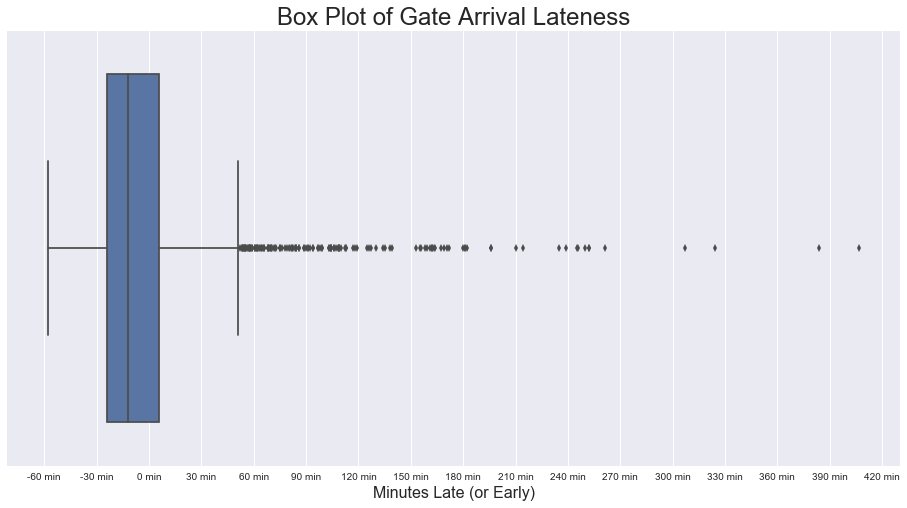

In [738]:
plt.figure(figsize=(16,8))
sns.boxplot(AAL_unfiltered.lateness_arr)
plt.xlabel("Minutes Late (or Early)", fontsize=16)
plt.xticks(minutes_30, [str(i)+' min' for i in minutes_30])
plt.title("Box Plot of Gate Arrival Lateness", fontsize=24)

# plt.savefig('../img/hist_lateness_pre.png', dpi=200, bbox_inches = 'tight')
;

In [739]:
iqr = AAL_unfiltered.lateness_arr.quantile(0.75) - AAL_unfiltered.lateness_arr.quantile(0.25)
upper_whisker = AAL_unfiltered.lateness_arr.quantile(0.75) + 1.5 * iqr
upper_whisker

51.0

In [740]:
AAL_unfiltered.shape

(1836, 20)

In [741]:
AAL_unfiltered[AAL_unfiltered.lateness_arr > 51].shape

(151, 20)

The upper whisker of the box plot of **lateness_arr** (1.5x the IQR) is only 51 minutes. 151 entries out of 1836 (8%) were more than 51 minutes late. There certainly are unpredictable events which would cause extreme lateness, and the features of my model would be insufficent to predict their outcomes, so there should be a threshold at which I filter them out as outliers due to extreme circumstances. Not sure whether to set this at 51 minutes or something higher.

For the purposes of modeling, I'll set it at 1 hr (51 min), unless I can argue a better prospect.

*Note: I've already done this in the cleaning function, and the AAL dataframe reflects the change.*

In [687]:
AAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 3 to 1926
Data columns (total 20 columns):
airline          1685 non-null object
f_num            1685 non-null object
origin           1685 non-null object
dest             1685 non-null object
date             1685 non-null object
land_act         1685 non-null datetime64[ns]
land_sch         1685 non-null datetime64[ns]
arr_act          1685 non-null datetime64[ns]
arr_sch          1685 non-null datetime64[ns]
lateness_land    1685 non-null int64
lateness_arr     1685 non-null int64
taxi_act         1685 non-null int64
taxi_sch         1685 non-null int64
hour_of_day      1685 non-null int64
q_of_day         1685 non-null int64
weekday          1685 non-null int64
land_act_t       1685 non-null object
land_sch_t       1685 non-null object
arr_act_t        1685 non-null object
arr_sch_t        1685 non-null object
dtypes: datetime64[ns](4), int64(7), object(9)
memory usage: 276.4+ KB


In [765]:
AAL.describe()

,lateness_land,lateness_arr,taxi_act,taxi_sch,hour_of_day,q_of_day,weekday
count,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000
mean,7.375074,-10.915134,16.528783,34.818991,14.434421,1.975074,2.785757
std,29.929697,20.120493,8.125203,20.884676,4.350581,0.768653,1.981455
min,-45.000000,-58.000000,0.000000,0.000000,8.000000,1.000000,0.000000
25%,-19.000000,-25.000000,11.000000,14.000000,11.000000,1.000000,1.000000
50%,8.000000,-14.000000,16.000000,40.000000,14.000000,2.000000,3.000000
75%,27.000000,0.000000,19.000000,55.000000,18.000000,3.000000,4.000000
max,100.000000,51.000000,68.000000,77.000000,23.000000,3.000000,6.000000


In [690]:
(AAL.sort_values(by='lateness_arr', 
                ascending=False
                )
 .head(5))

,airline,f_num,origin,dest,date,land_act,land_sch,arr_act,arr_sch,lateness_land,lateness_arr,taxi_act,taxi_sch,hour_of_day,q_of_day,weekday,land_act_t,land_sch_t,arr_act_t,arr_sch_t
924,American,AAL390,LGA,ORD,2017-05-22,2017-05-22 14:59:00,2017-05-22 13:30:00,2017-05-22 15:11:00,2017-05-22 14:20:00,89,51,12,50,14,2,0,14:59:00,13:30:00,15:11:00,14:20:00
1090,American,AAL328,LGA,ORD,2017-09-10,2017-09-10 12:45:00,2017-09-10 11:57:00,2017-09-10 13:06:00,2017-09-10 12:15:00,48,51,21,18,12,2,6,12:45:00,11:57:00,13:06:00,12:15:00
1406,American,AAL1619,LGA,ORD,2017-08-04,2017-08-04 10:50:00,2017-08-04 09:53:00,2017-08-04 11:06:00,2017-08-04 10:15:00,57,51,16,22,10,1,4,10:50:00,09:53:00,11:06:00,10:15:00
1697,American,AAL304,LGA,ORD,2017-06-23,2017-06-23 08:49:00,2017-06-23 07:27:00,2017-06-23 09:00:00,2017-06-23 08:10:00,82,50,11,43,8,1,4,08:49:00,07:27:00,09:00:00,08:10:00
1014,American,AAL337,LGA,ORD,2017-07-07,2017-07-07 13:54:00,2017-07-07 12:32:00,2017-07-07 14:11:00,2017-07-07 13:21:00,82,50,17,49,13,2,4,13:54:00,12:32:00,14:11:00,13:21:00


### Some Plots

#### Histogram of Lateness (gate) by Hour

*Label these if you use them later*

In [691]:
# don't need this one after filtering...

# x = AAL.lateness_arr

# plt.figure(figsize=(16,8))
# plt.hist(x, bins=9, range=[-60, 480])
# plt.xticks(minutes, [str(i)+' hr' for i in hours])
# plt.xlabel("Lateness", fontsize=16)
# plt.ylabel("Frequency", fontsize=16)
# plt.title("Lateness of Gate Arrival (1-hr Intervals)", fontsize=24);

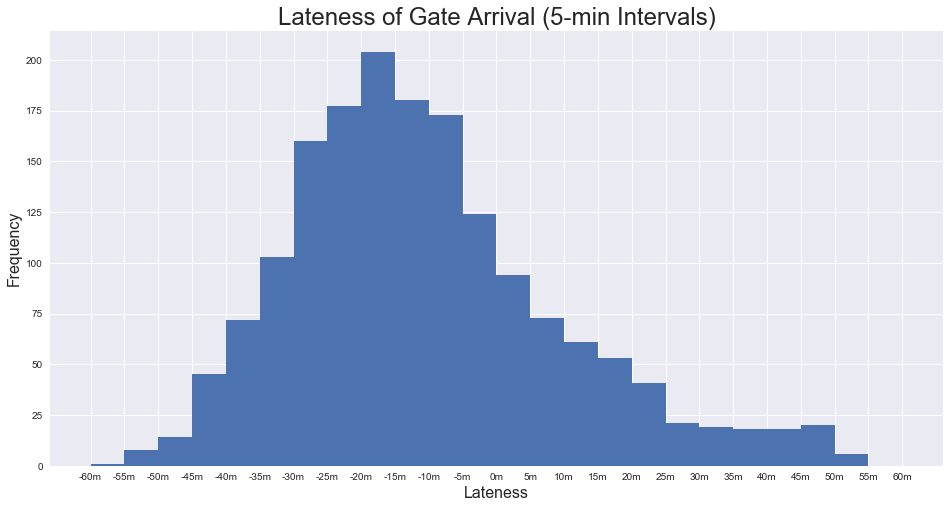

In [692]:
x = AAL.lateness_arr

plt.figure(figsize=(16,8))
plt.hist(x, bins=minutes_5, range=[-60,60])
plt.xticks(minutes_5, [str(i)+'m' for i in minutes_5])
plt.xlabel("Lateness", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Lateness of Gate Arrival (5-min Intervals)", fontsize=24);

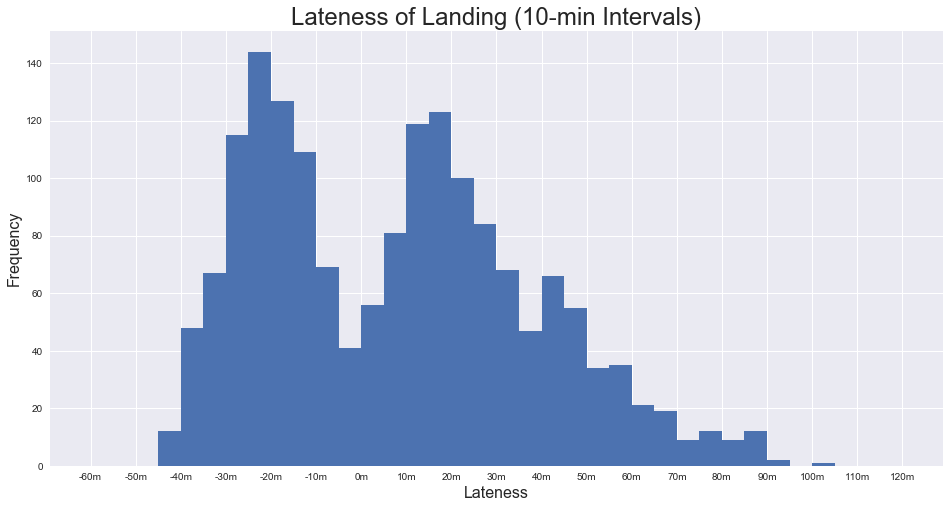

In [693]:
x = AAL.lateness_land

plt.figure(figsize=(16,8))
plt.hist(x, bins=minutes_5_3, range=[-60,120])
plt.xticks(minutes_10_3, [str(i)+'m' for i in minutes_10_3])
plt.xlabel("Lateness", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Lateness of Landing (10-min Intervals)", fontsize=24);

Lateness of landings is multimodal, whereas lateness of gate arrivals is decidedly not... odd!

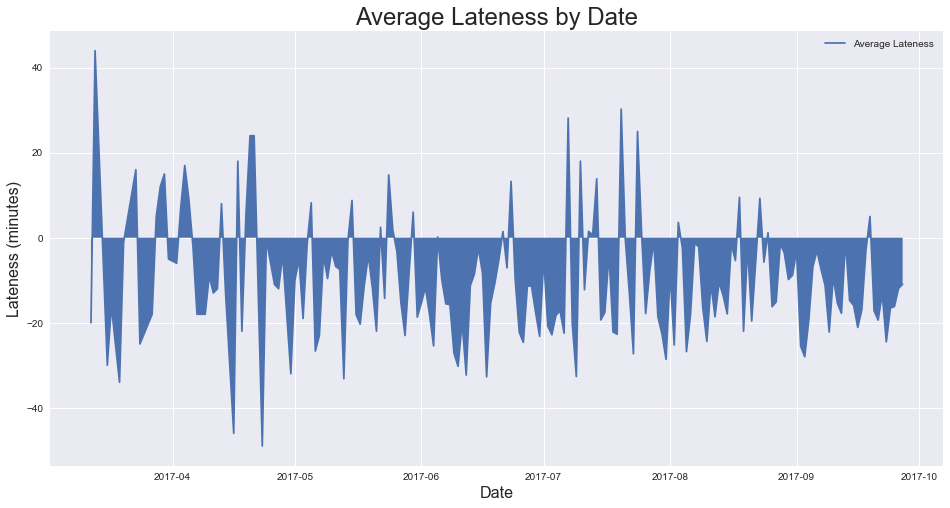

In [694]:
x = AAL.sort_values(by='date').groupby('date').lateness_arr.mean().index
y = AAL.sort_values(by='date').groupby('date').lateness_arr.mean()
# y0 = [0] * len(y)

plt.figure(figsize=(16,8))
plt.plot(x, y, label="Average Lateness")
# plt.plot(x, y0, "r-", label="On Time")
plt.legend()
plt.fill_between(x,y,0)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Lateness (minutes)", fontsize=16)
plt.title("Average Lateness by Date", fontsize=24);

Doesn't really tell us anything interesting...

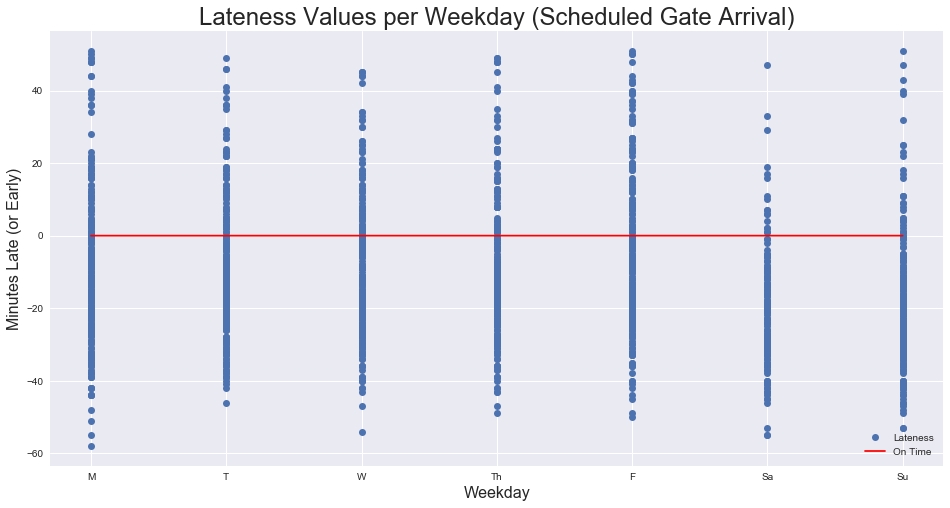

In [695]:
x = AAL.sort_values(by=['weekday', 'date']).weekday
y = AAL.sort_values(by=['weekday', 'date']).lateness_arr
y0 = [0] * len(x)

plt.figure(figsize=(16,8))
plt.plot(x, y, "o", label="Lateness")
plt.plot(x, y0, "r-", label="On Time")
plt.xlabel("Weekday", fontsize=16)
plt.ylabel("Minutes Late (or Early)", fontsize=16)
plt.xticks(range(7), days)
plt.legend()
plt.title("Lateness Values per Weekday (Scheduled Gate Arrival)", fontsize=24);

Looks like there might be a slight variation from day to day.

''

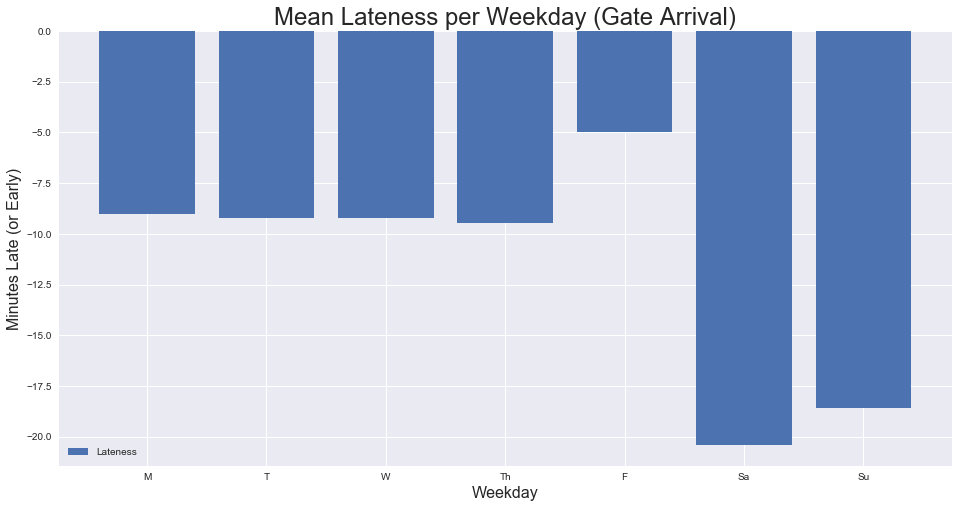

In [782]:
x = list(range(0,7))
y = AAL.groupby('weekday').lateness_arr.mean()

plt.figure(figsize=(16,8))
plt.bar(x, y, label="Lateness")
# sns.barplot(x,y)
plt.legend()
plt.xlabel("Weekday", fontsize=16)
plt.ylabel("Minutes Late (or Early)", fontsize=16)
plt.xticks(range(7), days)
plt.title("Mean Lateness per Weekday (Gate Arrival)", fontsize=24)

plt.savefig('../img/weekday.png', dpi=200, bbox_inches = 'tight')
;

Friday seems to be the day of most lateness; the weekends the days of least.

''

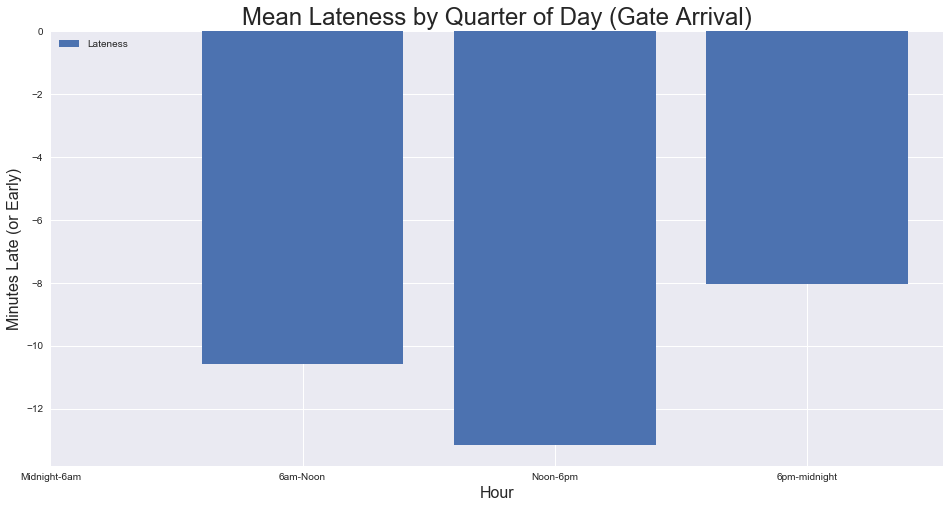

In [781]:
temp = AAL.groupby('q_of_day').mean()

x = temp.index
y = temp.lateness_arr

plt.figure(figsize=(16,8))
plt.bar(x, y, label="Lateness")
# plt.hist(AAL.q_of_day, bins=4, range=[0,4])
plt.legend()
plt.xlabel("Hour", fontsize=16)
plt.ylabel("Minutes Late (or Early)", fontsize=16)
plt.xticks(range(4), ['Midnight-6am', '6am-Noon', 'Noon-6pm', '6pm-midnight'])
plt.title("Mean Lateness by Quarter of Day (Gate Arrival)", fontsize=24)

plt.savefig('../img/quarter_bar.png', dpi=200, bbox_inches = 'tight')
;

''

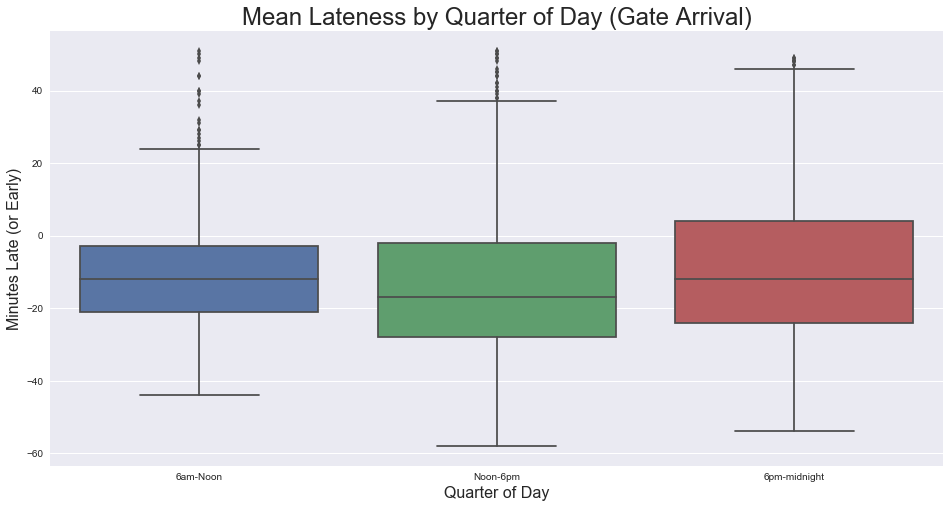

In [780]:
plt.figure(figsize=(16,8))
sns.boxplot(x=AAL.q_of_day, y=AAL.lateness_arr)
plt.xlabel("Quarter of Day", fontsize=16)
plt.ylabel("Minutes Late (or Early)", fontsize=16)
plt.xticks(range(3), ['6am-Noon', 'Noon-6pm', '6pm-midnight'])
plt.title("Mean Lateness by Quarter of Day (Gate Arrival)", fontsize=24)

plt.savefig('../img/quarter_box.png', dpi=200, bbox_inches = 'tight')
;

I want to look at lateness per hour of day, to make sure my quarters are capturing anything useful. We need another column for that (adding to cleaning function).

In [700]:
# Now done in cleaning step
# AAL['hour'] = AAL.apply(lambda x: x.arr_sch.hour, axis=1)

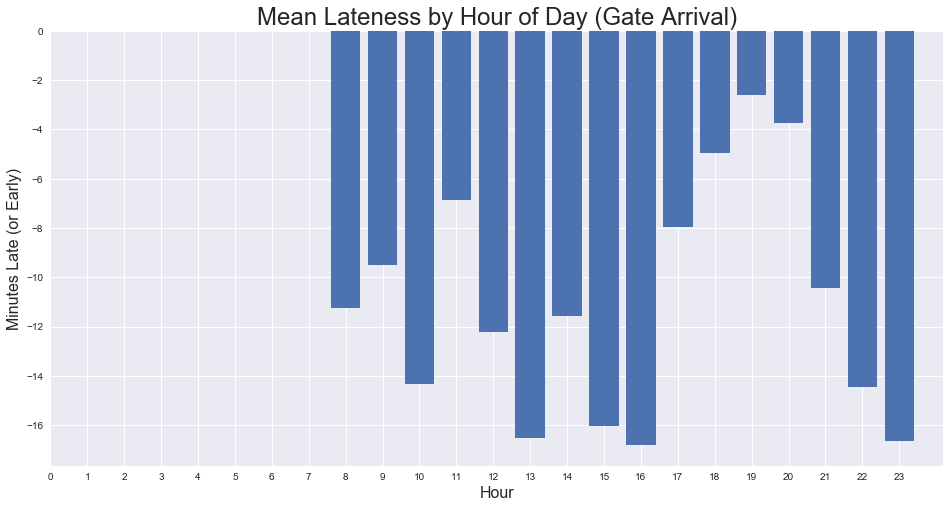

In [779]:
# relabel this one to make it clearer

temp = AAL.groupby('hour_of_day').mean()

x = temp.index
y = temp.lateness_arr

plt.figure(figsize=(16,8))
plt.bar(x, y, label="Lateness (negative for early)")
# plt.hist(AAL.hour, bins=24, range=[0,24])
# plt.legend()
plt.xticks(range(24), [i for i in range(24)])
plt.xlabel("Hour", fontsize=16)
plt.ylabel("Minutes Late (or Early)", fontsize=16)
plt.title("Mean Lateness by Hour of Day (Gate Arrival)", fontsize=24);

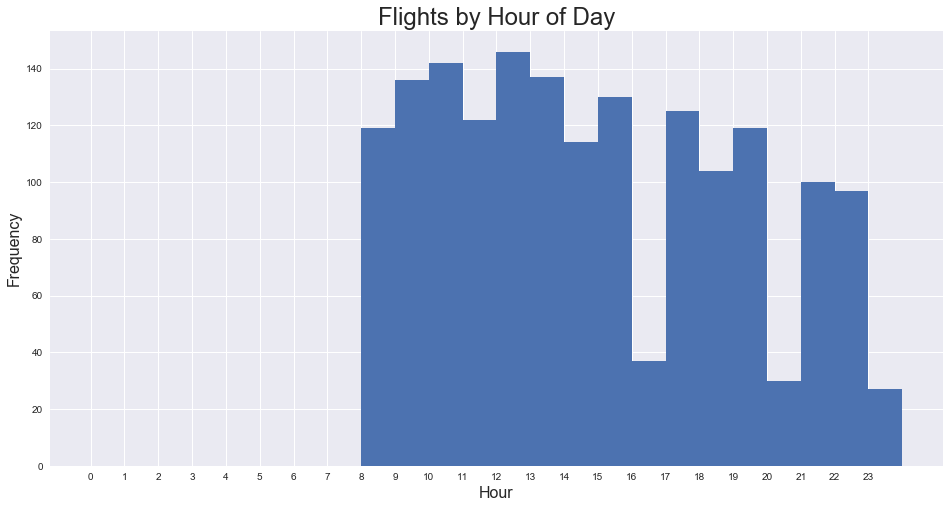

In [703]:
x = AAL.hour_of_day

plt.figure(figsize=(16,8))
plt.hist(x, bins=24, range=(0,24))
plt.xticks(range(24), [i for i in range(24)])
plt.xlabel("Hour", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Flights by Hour of Day", fontsize=24);

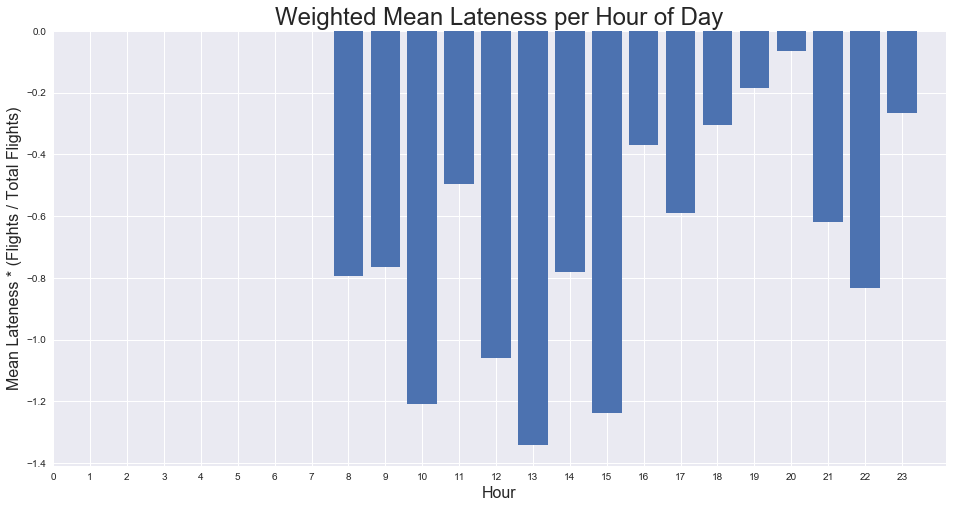

In [705]:
temp = AAL.groupby('hour_of_day').lateness_arr.agg(['mean', 'count'])
temp['w_mean'] = temp['mean'] * temp['count'] / len(AAL)

x = temp.index
y = temp.w_mean

plt.figure(figsize=(16,8))
plt.bar(x, y, label="Lateness (negative for early)")
# plt.hist(AAL.hour, bins=24, range=[0,24])
# plt.legend()
plt.xticks(range(24), [i for i in range(24)])
plt.xlabel("Hour", fontsize=16)
plt.ylabel("Mean Lateness * (Flights / Total Flights)", fontsize=16)
plt.title("Weighted Mean Lateness per Hour of Day", fontsize=24);

Do a plot of mean weighted by number of flights during that hour?

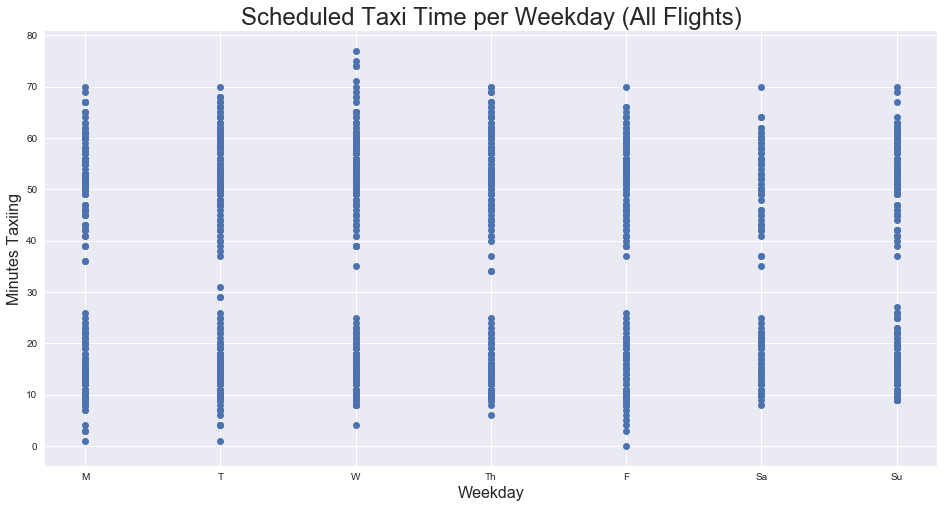

In [706]:
x = AAL.sort_values(by=['weekday', 'date']).weekday
y = AAL.sort_values(by=['weekday', 'date']).taxi_sch

plt.figure(figsize=(16,8))
plt.plot(x, y, "o", label="Taxi Time")
plt.xlabel("Weekday", fontsize=16)
plt.ylabel("Minutes Taxiing", fontsize=16)
# plt.legend()
plt.xticks(range(7), days)
plt.title("Scheduled Taxi Time per Weekday (All Flights)", fontsize=24);

The presence of two distinct groups per day leads me to believe that this is probably a result of the multimodal pattern seen in landing lateness, as "scheduled" taxi time is the result of subtracting scheduled landing time from scheduled gate arrival time. There's no way of knowing if the posted landing time was scheduled weeks in advance or right before take-off, but I'll assume for our purposes that it's known enough in advance to be useful as a predictor.

''

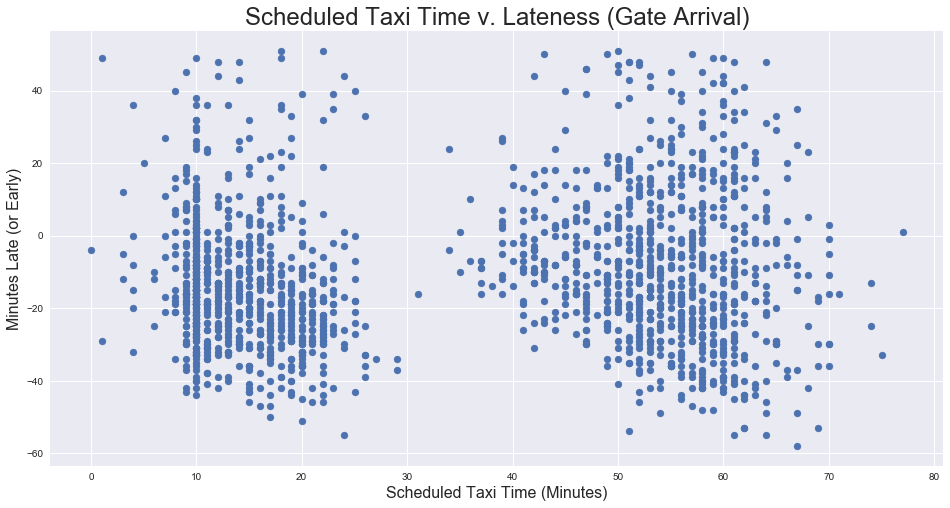

In [778]:
x = AAL.taxi_sch
y = AAL.lateness_arr

plt.figure(figsize=(16,8))
plt.scatter(x, y)
plt.xlabel("Scheduled Taxi Time (Minutes)", fontsize=16)
plt.ylabel("Minutes Late (or Early)", fontsize=16)
# plt.legend()
# plt.xticks(range(7), days)
plt.title("Scheduled Taxi Time v. Lateness (Gate Arrival)", fontsize=24)

plt.savefig('../img/taxi_scatter.png', dpi=200, bbox_inches = 'tight')
;

## Cleaning Prep

Performed on one batch of raw, scraped data while the others were scraping.

In [258]:
with open('../data/AAL343_1003_210250.pkl', 'rb') as pf: 
    df = pickle.load(pf)

Columns with **land** in the title refer to landing time; columns with **arr** in the title refer to gate arrival. The latter is the one officials listed as the arrival time, so I'll be focusing on this one.

In [259]:
df.head()

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch
0,American,AAL345,LGA,ORD,2017-10-02,2017-10-02 18:45:00,2017-10-02 19:01:00,2017-10-02 19:01:00,2017-10-02 19:16:00
1,American,AAL345,LGA,ORD,2017-10-01,2017-10-01 19:00:00,2017-10-01 19:20:00,2017-10-01 19:02:00,2017-10-01 19:16:00
2,American,AAL345,LGA,ORD,2017-09-29,2017-09-29 18:44:00,2017-09-29 19:01:00,2017-09-29 19:10:00,2017-09-29 19:16:00
3,American,AAL345,LGA,ORD,2017-09-28,2017-09-28 19:11:00,2017-09-28 19:23:00,2017-09-28 19:08:00,2017-09-28 19:16:00
4,American,AAL345,LGA,ORD,2017-09-27,2017-09-27 19:01:00,2017-09-27 19:18:00,2017-09-27 19:06:00,2017-09-27 19:16:00


Creates **lateness_land** and **lateness_arr** column in minutes, where positive indicates late and negative indicates early.

In [260]:
# def diff_minutes(a, b):
#     diff = int((a.timestamp() - b.timestamp()) // 60)
#     return diff

In [261]:
types = ['land', 'arr']

In [262]:
for n in types:
    df['lateness_' + n] = (df
     .apply(lambda row: diff_minutes(row[n + '_act'], row[n + '_sch']), axis=1))

# df['lateness_arr'] = (df
#  .apply(lambda row: diff_minutes(row.arr_act, row.arr_sch), axis=1))

In [263]:
for n in types:
    print(df['lateness_' + n].describe(), '\n')

count    226.000000
mean      23.185841
std       86.810040
min     -998.000000
25%      -14.000000
50%       20.000000
75%       48.750000
max      194.000000
Name: lateness_land, dtype: float64 

count     226.000000
mean        7.000000
std        84.019998
min     -1056.000000
25%       -18.000000
50%        -0.500000
75%        24.750000
max       182.000000
Name: lateness_arr, dtype: float64 



It would be impossible for a plane to be -1056 minutes late (nearly 18 hours early). An investigation...

In [264]:
df.sort_values(by='lateness_arr').head(10)

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch,lateness_land,lateness_arr
164,American,AAL343,LGA,ORD,2017-08-03,2017-08-03 00:43:00,2017-08-03 00:50:00,2017-08-03 17:21:00,2017-08-03 18:26:00,-998,-1056
196,American,AAL343,LGA,ORD,2017-06-11,2017-06-11 17:20:00,2017-06-11 17:33:00,2017-06-11 17:17:00,2017-06-11 18:26:00,3,-53
127,American,AAL343,LGA,ORD,2017-09-21,2017-09-21 17:21:00,2017-09-21 17:33:00,2017-09-21 18:04:00,2017-09-21 18:20:00,-43,-47
177,American,AAL343,LGA,ORD,2017-07-09,2017-07-09 17:28:00,2017-07-09 17:40:00,2017-07-09 17:22:00,2017-07-09 18:26:00,6,-46
130,American,AAL343,LGA,ORD,2017-09-16,2017-09-16 17:28:00,2017-09-16 17:35:00,2017-09-16 18:00:00,2017-09-16 18:20:00,-32,-45
187,American,AAL343,LGA,ORD,2017-06-26,2017-06-26 17:36:00,2017-06-26 17:42:00,2017-06-26 17:24:00,2017-06-26 18:26:00,12,-44
188,American,AAL343,LGA,ORD,2017-06-25,2017-06-25 17:36:00,2017-06-25 17:44:00,2017-06-25 17:26:00,2017-06-25 18:26:00,10,-42
182,American,AAL343,LGA,ORD,2017-07-02,2017-07-02 17:35:00,2017-07-02 17:45:00,2017-07-02 17:25:00,2017-07-02 18:26:00,10,-41
195,American,AAL343,LGA,ORD,2017-06-12,2017-06-12 17:34:00,2017-06-12 17:50:00,2017-06-12 17:17:00,2017-06-12 18:26:00,17,-36
73,American,AAL345,LGA,ORD,2017-06-26,2017-06-26 18:39:00,2017-06-26 18:49:00,2017-06-26 18:23:00,2017-06-26 19:24:00,16,-35


One flight didn't get in until the next day, and since FlightAware only lists a time of landing and not the date, it gets stamped with the same date as the scheduled arrival, so the actual arrival in this case seems to be much earlier even though it is almost six hours late.

Adding 24 hours (1440 minutes) will remedy this. Since it's a ~2 hr flight, I will assume that a flight cannot possibly be more than 2 hours early, and will add 1440 to any 'lateness' value less than -120 minutes.

I'll also advance the corresponding arrival date(s) by one day in order to accurately indicate the exact arrival time (not important for regression, but matters with plotting).

First, advancing dates where flights landed and/or arrived after midnight:

In [265]:
for n in types:
    df.loc[df['lateness_' + n] < -120, n + '_act'] = (df[n + '_act']
     .apply(lambda x: x + timedelta(days=1)))

In [266]:
df.sort_values(by='lateness_arr', ascending=True).head()

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch,lateness_land,lateness_arr
164,American,AAL343,LGA,ORD,2017-08-03,2017-08-04 00:43:00,2017-08-04 00:50:00,2017-08-03 17:21:00,2017-08-03 18:26:00,-998,-1056
196,American,AAL343,LGA,ORD,2017-06-11,2017-06-11 17:20:00,2017-06-11 17:33:00,2017-06-11 17:17:00,2017-06-11 18:26:00,3,-53
127,American,AAL343,LGA,ORD,2017-09-21,2017-09-21 17:21:00,2017-09-21 17:33:00,2017-09-21 18:04:00,2017-09-21 18:20:00,-43,-47
177,American,AAL343,LGA,ORD,2017-07-09,2017-07-09 17:28:00,2017-07-09 17:40:00,2017-07-09 17:22:00,2017-07-09 18:26:00,6,-46
130,American,AAL343,LGA,ORD,2017-09-16,2017-09-16 17:28:00,2017-09-16 17:35:00,2017-09-16 18:00:00,2017-09-16 18:20:00,-32,-45


And correcting the lateness values:

In [267]:
for n in types:
    col = 'lateness_' + n
    df.loc[(df[col] < -120), col] = df[col] + 1440
    
# df.loc[(df.lateness_sch < -120), 'lateness_sch'] = df.lateness_sch + 1440

In [268]:
df.iloc[164]

airline                     American
f_num                         AAL343
origin                           LGA
dest                             ORD
date                      2017-08-03
land_act         2017-08-04 00:43:00
arr_act          2017-08-04 00:50:00
land_sch         2017-08-03 17:21:00
arr_sch          2017-08-03 18:26:00
lateness_land                    442
lateness_arr                     384
Name: 164, dtype: object

In [269]:
for n in types:
    print(df['lateness_' + n].describe(), '\n')

count    226.000000
mean      29.557522
std       60.332624
min      -45.000000
25%      -14.000000
50%       20.000000
75%       49.000000
max      442.000000
Name: lateness_land, dtype: float64 

count    226.000000
mean      13.371681
std       51.265790
min      -53.000000
25%      -18.000000
50%        0.000000
75%       25.000000
max      384.000000
Name: lateness_arr, dtype: float64 



**Very interesting that the median lateness_arr is exactly 0** after correcting for the above. One might suppose that the airlines (or at least American) may be scheduling their arrival times such that 50% of the flights are "early." This is just a sample of the entire data set; curious to see if that holds up when all records are accounted for.

Now that arrival dates are corrected, any further subtractions will be legit. I'll make two new columns, one for scheduled taxi time, and one for actual taxi time:

In [270]:
for n in ['act', 'sch']:
    df['taxi_' + n] = (df
     .apply(lambda row: diff_minutes(row['arr_' + n], row['land_' + n]), axis=1))

In [274]:
df = df.filter(['airline', 
          'f_num', 
          'origin', 
          'dest', 
          'date', 
          'land_act', 
          'land_sch', 
          'arr_act', 
          'arr_sch', 
          'lateness_land',
          'lateness_arr',
          'taxi_act',
          'taxi_sch'])

In [275]:
df.sort_values(by='taxi_sch').head()

,airline,f_num,origin,dest,date,land_act,land_sch,arr_act,arr_sch,lateness_land,lateness_arr,taxi_act,taxi_sch
41,American,AAL345,LGA,ORD,2017-08-10,2017-08-10 19:22:00,2017-08-10 19:35:00,2017-08-10 19:32:00,2017-08-10 19:24:00,-13,8,10,-11
34,American,AAL345,LGA,ORD,2017-08-18,2017-08-18 19:23:00,2017-08-18 19:34:00,2017-08-18 19:38:00,2017-08-18 19:24:00,-11,14,15,-10
40,American,AAL345,LGA,ORD,2017-08-11,2017-08-11 19:02:00,2017-08-11 19:28:00,2017-08-11 19:10:00,2017-08-11 19:24:00,-26,-14,8,-4
160,American,AAL343,LGA,ORD,2017-08-11,2017-08-11 18:14:00,2017-08-11 18:28:00,2017-08-11 18:27:00,2017-08-11 18:26:00,-14,1,13,-2
172,American,AAL343,LGA,ORD,2017-07-18,2017-07-18 17:40:00,2017-07-18 18:22:00,2017-07-18 17:54:00,2017-07-18 18:26:00,-42,-32,14,4


Negative scheduled taxi time? Odd. Means that the scheuded gate arrival time is sooner than the scheduled landing time, which would be impossible. Not knowing how this comes about, I'll toss rows where **taxi_sch** < 0.

In [284]:
df.drop(df[df.taxi_sch < 0].index, inplace=True)

If I want to look at time of day, I'll break the day into quarters based on **arr_sch** and treat TOD categorically.

In [307]:
# def day_quarters(dt_obj):
#     """
#     Given a datetime object, extracts the hour, then returns a number (int)
#     0-3 indicating the quarter of the day.
#     """
#     h = dt_obj.hour
    
#     if h < 6:
#         q = 0
#     elif 6 <= h < 12:
#         q = 1
#     elif 12 <= h < 18:
#         q = 2
#     else:
#         q = 3
    
#     return q

In [308]:
df['q_of_day'] = df.apply(lambda x: day_quarters(x.arr_sch), axis=1)

In [309]:
df.sample(5)

,airline,f_num,origin,dest,date,land_act,land_sch,arr_act,arr_sch,lateness_land,lateness_arr,taxi_act,taxi_sch,q_of_day
157,American,AAL343,LGA,ORD,2017-08-15,2017-08-15 17:39:00,2017-08-15 18:16:00,2017-08-15 18:02:00,2017-08-15 18:26:00,-37,-24,23,10,3
123,American,AAL343,LGA,ORD,2017-09-25,2017-09-25 17:58:00,2017-09-25 18:07:00,2017-09-25 18:27:00,2017-09-25 18:20:00,-9,7,29,13,3
145,American,AAL343,LGA,ORD,2017-08-30,2017-08-30 18:16:00,2017-08-30 18:06:00,2017-08-30 18:46:00,2017-08-30 18:20:00,10,26,30,14,3
50,American,AAL345,LGA,ORD,2017-07-28,2017-07-28 19:23:00,2017-07-28 19:10:00,2017-07-28 20:07:00,2017-07-28 19:24:00,13,43,44,14,3
127,American,AAL343,LGA,ORD,2017-09-21,2017-09-21 17:21:00,2017-09-21 18:04:00,2017-09-21 17:33:00,2017-09-21 18:20:00,-43,-47,12,16,3


I'll need a column to indicate day of the week so I can build dummy columns come time for regression:

In [310]:
df['weekday'] = df.apply(lambda x: x.arr_sch.weekday(), axis=1)

And it may be advantageous to have just the times without the date (for plotting):

In [311]:
for col in df.columns[5:9]:
    df[col+'_t'] = df.apply(lambda row: row[col].time(), axis=1)

In [312]:
df.head(5)

,airline,f_num,origin,dest,date,land_act,land_sch,arr_act,arr_sch,lateness_land,lateness_arr,taxi_act,taxi_sch,q_of_day,weekday,land_act_t,land_sch_t,arr_act_t,arr_sch_t
0,American,AAL345,LGA,ORD,2017-10-02,2017-10-02 18:45:00,2017-10-02 19:01:00,2017-10-02 19:01:00,2017-10-02 19:16:00,-16,-15,16,15,3,0,18:45:00,19:01:00,19:01:00,19:16:00
1,American,AAL345,LGA,ORD,2017-10-01,2017-10-01 19:00:00,2017-10-01 19:02:00,2017-10-01 19:20:00,2017-10-01 19:16:00,-2,4,20,14,3,6,19:00:00,19:02:00,19:20:00,19:16:00
2,American,AAL345,LGA,ORD,2017-09-29,2017-09-29 18:44:00,2017-09-29 19:10:00,2017-09-29 19:01:00,2017-09-29 19:16:00,-26,-15,17,6,3,4,18:44:00,19:10:00,19:01:00,19:16:00
3,American,AAL345,LGA,ORD,2017-09-28,2017-09-28 19:11:00,2017-09-28 19:08:00,2017-09-28 19:23:00,2017-09-28 19:16:00,3,7,12,8,3,3,19:11:00,19:08:00,19:23:00,19:16:00
4,American,AAL345,LGA,ORD,2017-09-27,2017-09-27 19:01:00,2017-09-27 19:06:00,2017-09-27 19:18:00,2017-09-27 19:16:00,-5,2,17,10,3,2,19:01:00,19:06:00,19:18:00,19:16:00
